# 1. Bayesian Inference

- https://bayesiancomputationbook.com/markdown/chp_01.html
- https://github.com/BayesianModelingandComputationInPython/BookCode_Edition1/blob/main/notebooks_updated/chp_01.ipynb

## 1.1. Bayesian Modeling

Models are human-designed representations with very specific goals in mind. As such, it is generally more convenient to talk about the adequacy of the model to a given problem than its intrinsic correctness. Models exist solely as an aid to a further goal.

Building a model requires a combination of domain expertise and statistical skill to incorporate knowledge into some computable objectives and determine the usefulness of the result.

### 1.1.1. Bayesian Models

Bayesian models, computational or otherwise, have two defining characteristics:
- Unknown quantities are described using probability distributions. We call these quantities parameters.
- Bayes’ theorem is used to update the values of the parameters conditioned on the data.

### 1.1.2. Bayesian Inference

Bayesian inference is a particular form of statistical inference based on combining probability distributions in order to obtain other probability distributions.

Bayes’ theorem provides us with a general recipe to estimate the value of the parameter $\pmb{\theta}$ given that we have observed some data $\pmb{Y}$:

$$ 
\underbrace{ p(\pmb{\theta} \mid \pmb{Y}) }_{\text{posterior}} =
\frac{\overbrace{p(\pmb{Y} \mid \pmb{\theta})}^{\text{likelihood}} \; \overbrace{p(\pmb{\theta})}^{\text{prior}}}{\underbrace{p(\pmb{Y})}_{\text{marginal likelihood}}}
$$

The likelihood function links the observed data with the unknown parameters while the prior distribution represents the uncertainty about the parameters before observing the data. By multiplying them we obtain the posterior distribution, that is the joint distribution over all the parameters in the model (conditioned on the observed data).

As the marginal likelihood is not generally computed, it is very common to see Bayes’ theorem expressed as a proportionality:
$$ 
\underbrace{ p(\pmb{\theta} \mid \pmb{Y}) }_{\text{posterior}} \propto
\overbrace{p(\pmb{Y} \mid \pmb{\theta})}^{\text{likelihood}} \; \overbrace{p(\pmb{\theta})}^{\text{prior}}
$$

## 1.2. A DIY Sampler, Do Not Try This at Home

There are many algorithms that can be used as Universal Inference Engines. Probably the most widely adopted and powerful is the family of Markov chain Monte Carlo methods (MCMC). At a very high level, all MCMC methods approximate the posterior distribution using samples.

One such algorithm is Metropolis-Hastings.

- Beta-Binomial model

$$
\theta \sim \text{Beta}(\alpha, \beta)
$$

$$
Y \sim \text{Bin}(n=1, p=\theta)
$$

The parameter $\theta$ has $\text{Beta}(\alpha,\beta)$ as its prior distribution. We assume the data is distributed following a Binomial distribution $\text{Bin}(n=1, p=\theta)$, which represents our likelihood distribution.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats
from scipy.stats import entropy
from scipy.optimize import minimize

In [ ]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(521)

In [ ]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prop = like * prior
    else:
        prop = -np.inf
    return prop

In [ ]:
Y = stats.bernoulli(0.7).rvs(20)

In [ ]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5
trace = {'θ': np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1).item()
    p1 = post(θ_can, Y, α, β)
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace['θ'][iter] = θ

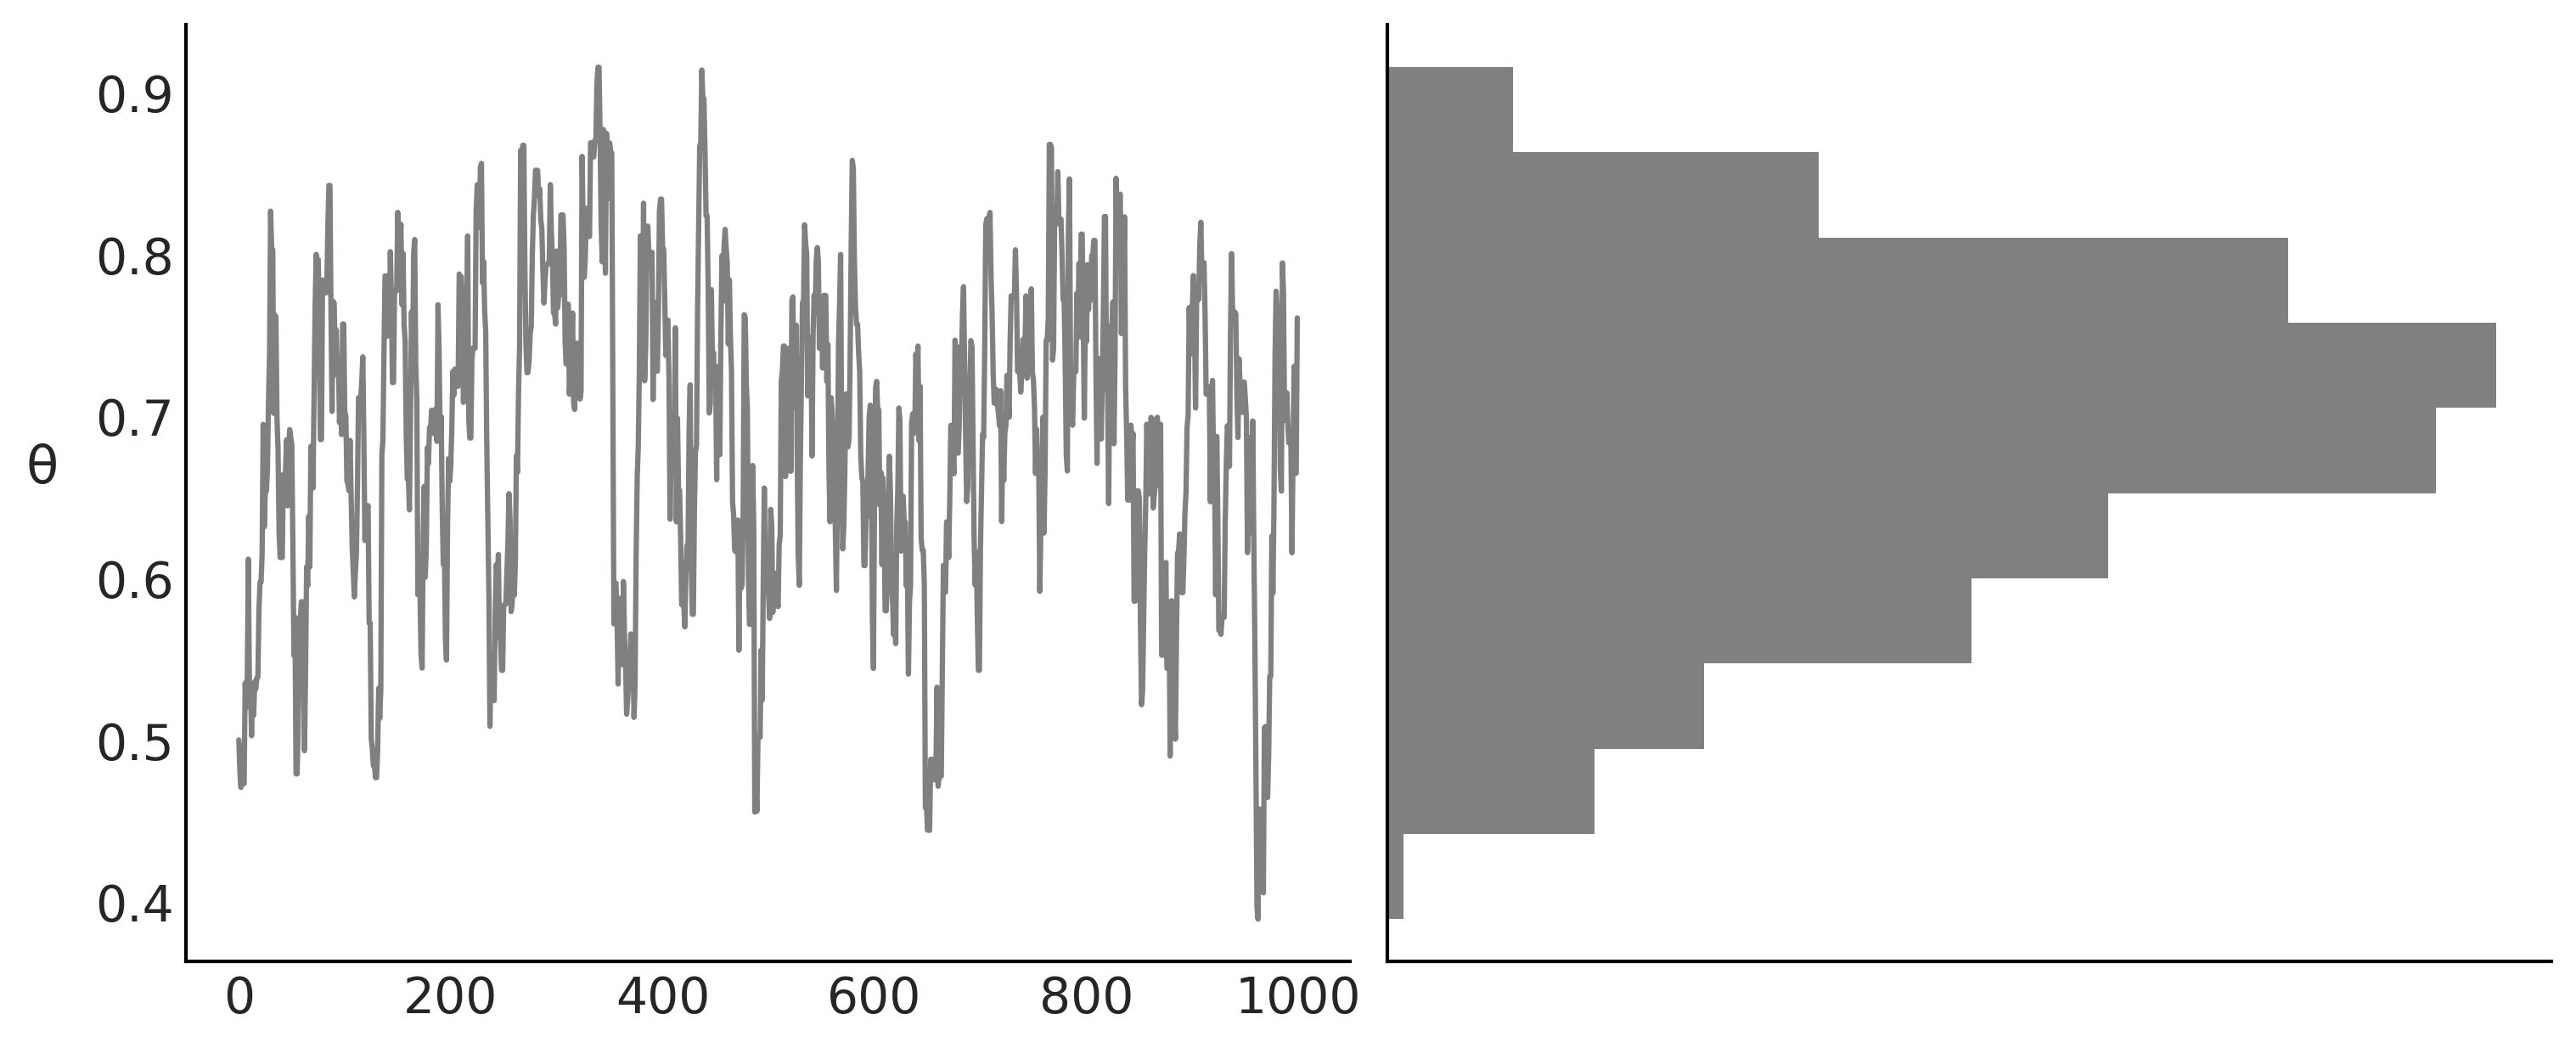

In [ ]:
_, axes = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True, sharey=True)
axes[1].hist(trace['θ'], color='0.5', orientation="horizontal", density=True)
axes[1].set_xticks([])
axes[0].plot(trace['θ'], '0.5')
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
plt.show()

> On the left, we have the sampled values of the parameter $\theta$ at each iteration. On the right, we have the histogram of the sampled values of $\theta$. The histogram is rotated, to make it easier to see that both plots are closely related. The plot on the left shows the sequence of sampled values. This sequence is our Markov Chain. The plot on the right shows the distribution of the sampled values.

In [ ]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
θ,0.69,0.1,0.51,0.87


ArviZ’s function `summary` computes the mean, standard deviation and the highest density interval (HDI) 94% of our parameter $\theta$. The HDI is the shortest interval containing a given probability density, 94% for this particular example.

<Axes: title={'center': 'θ'}>

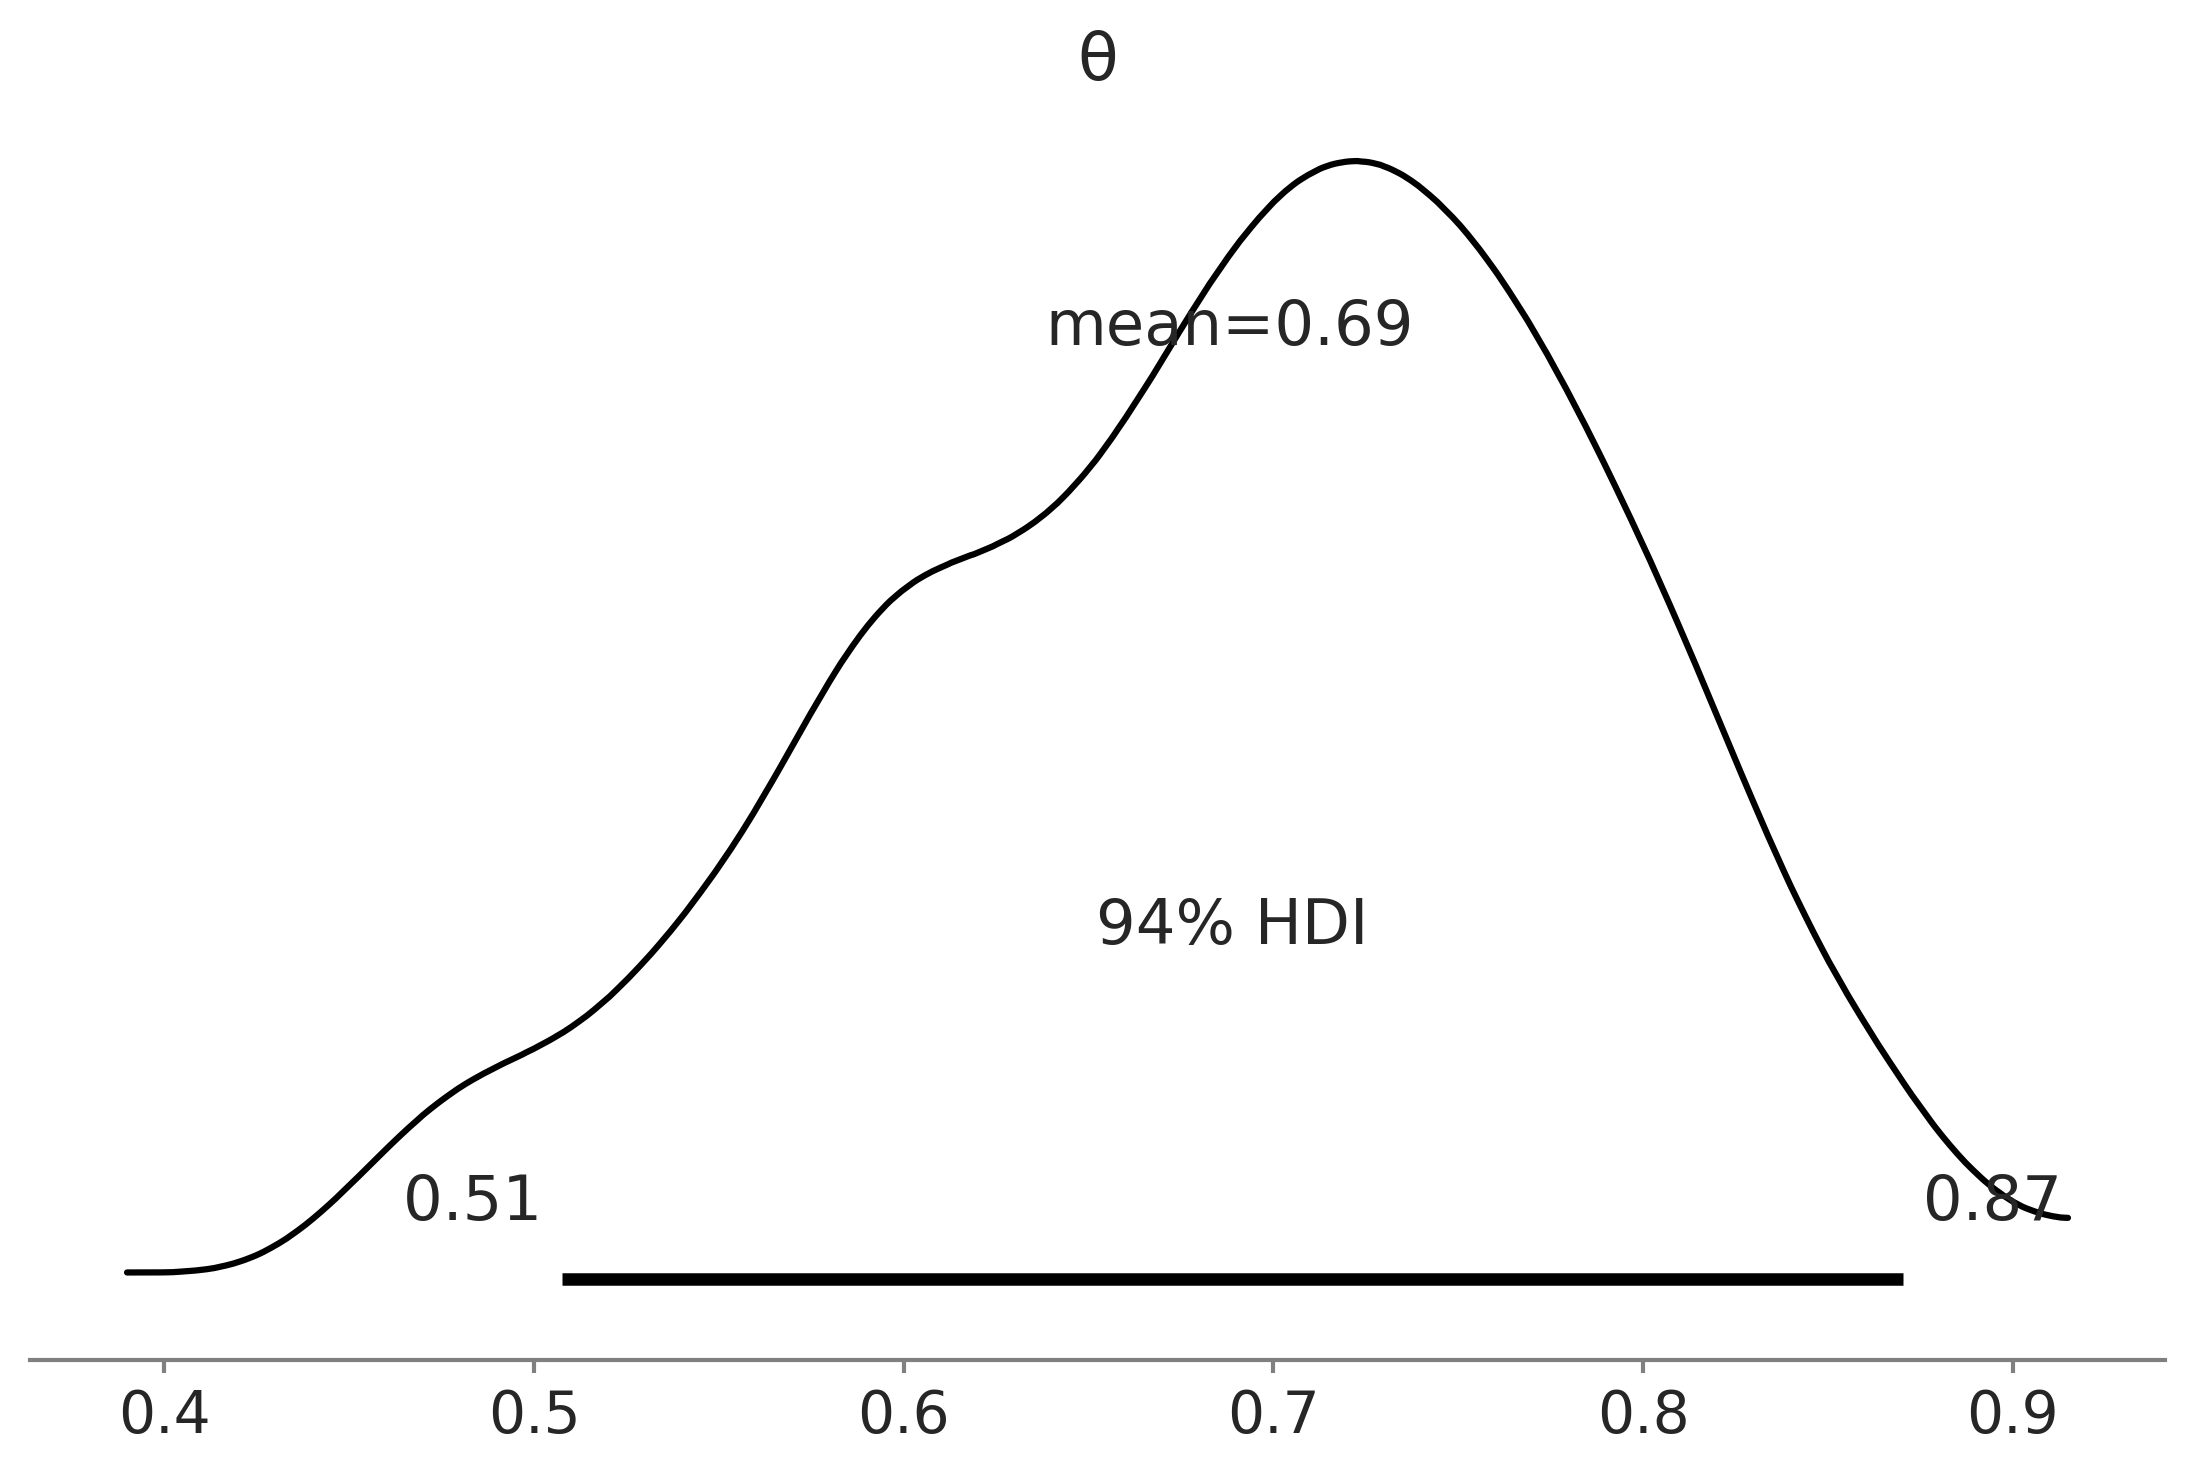

In [ ]:
az.plot_posterior(trace)

This is a close visual equivalent of the above summary. We can see the mean and the HDI, on top of a curve representing the entire posterior distribution. The curve is computed using a kernel density estimator (KDE), which is like the smooth version of a histogram.

## 1.3. Say Yes to Automating Inference, Say No to Automated Model Building

Instead of writing our own sampler and having to define our models using scipy.stats method we can leverage the aid of Probabilistic Programming Languages (PPL). These tools allow users to express Bayesian models using code and then perform Bayesian inference in a fairly automated fashion thanks to Universal Inference Engines. 

In [ ]:
# Declare a model in PyMC
with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    θ = pm.Beta("θ", alpha=1, beta=1)

    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

    # Sample from the posterior distribution
    idata = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


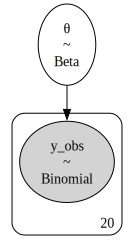

In [ ]:
graphviz = pm.model_to_graphviz(model)
graphviz

In [ ]:
pred_dists = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata, model).posterior_predictive["y_obs"].values)

Sampling: [y_obs, θ]
Sampling: [y_obs]


Output()

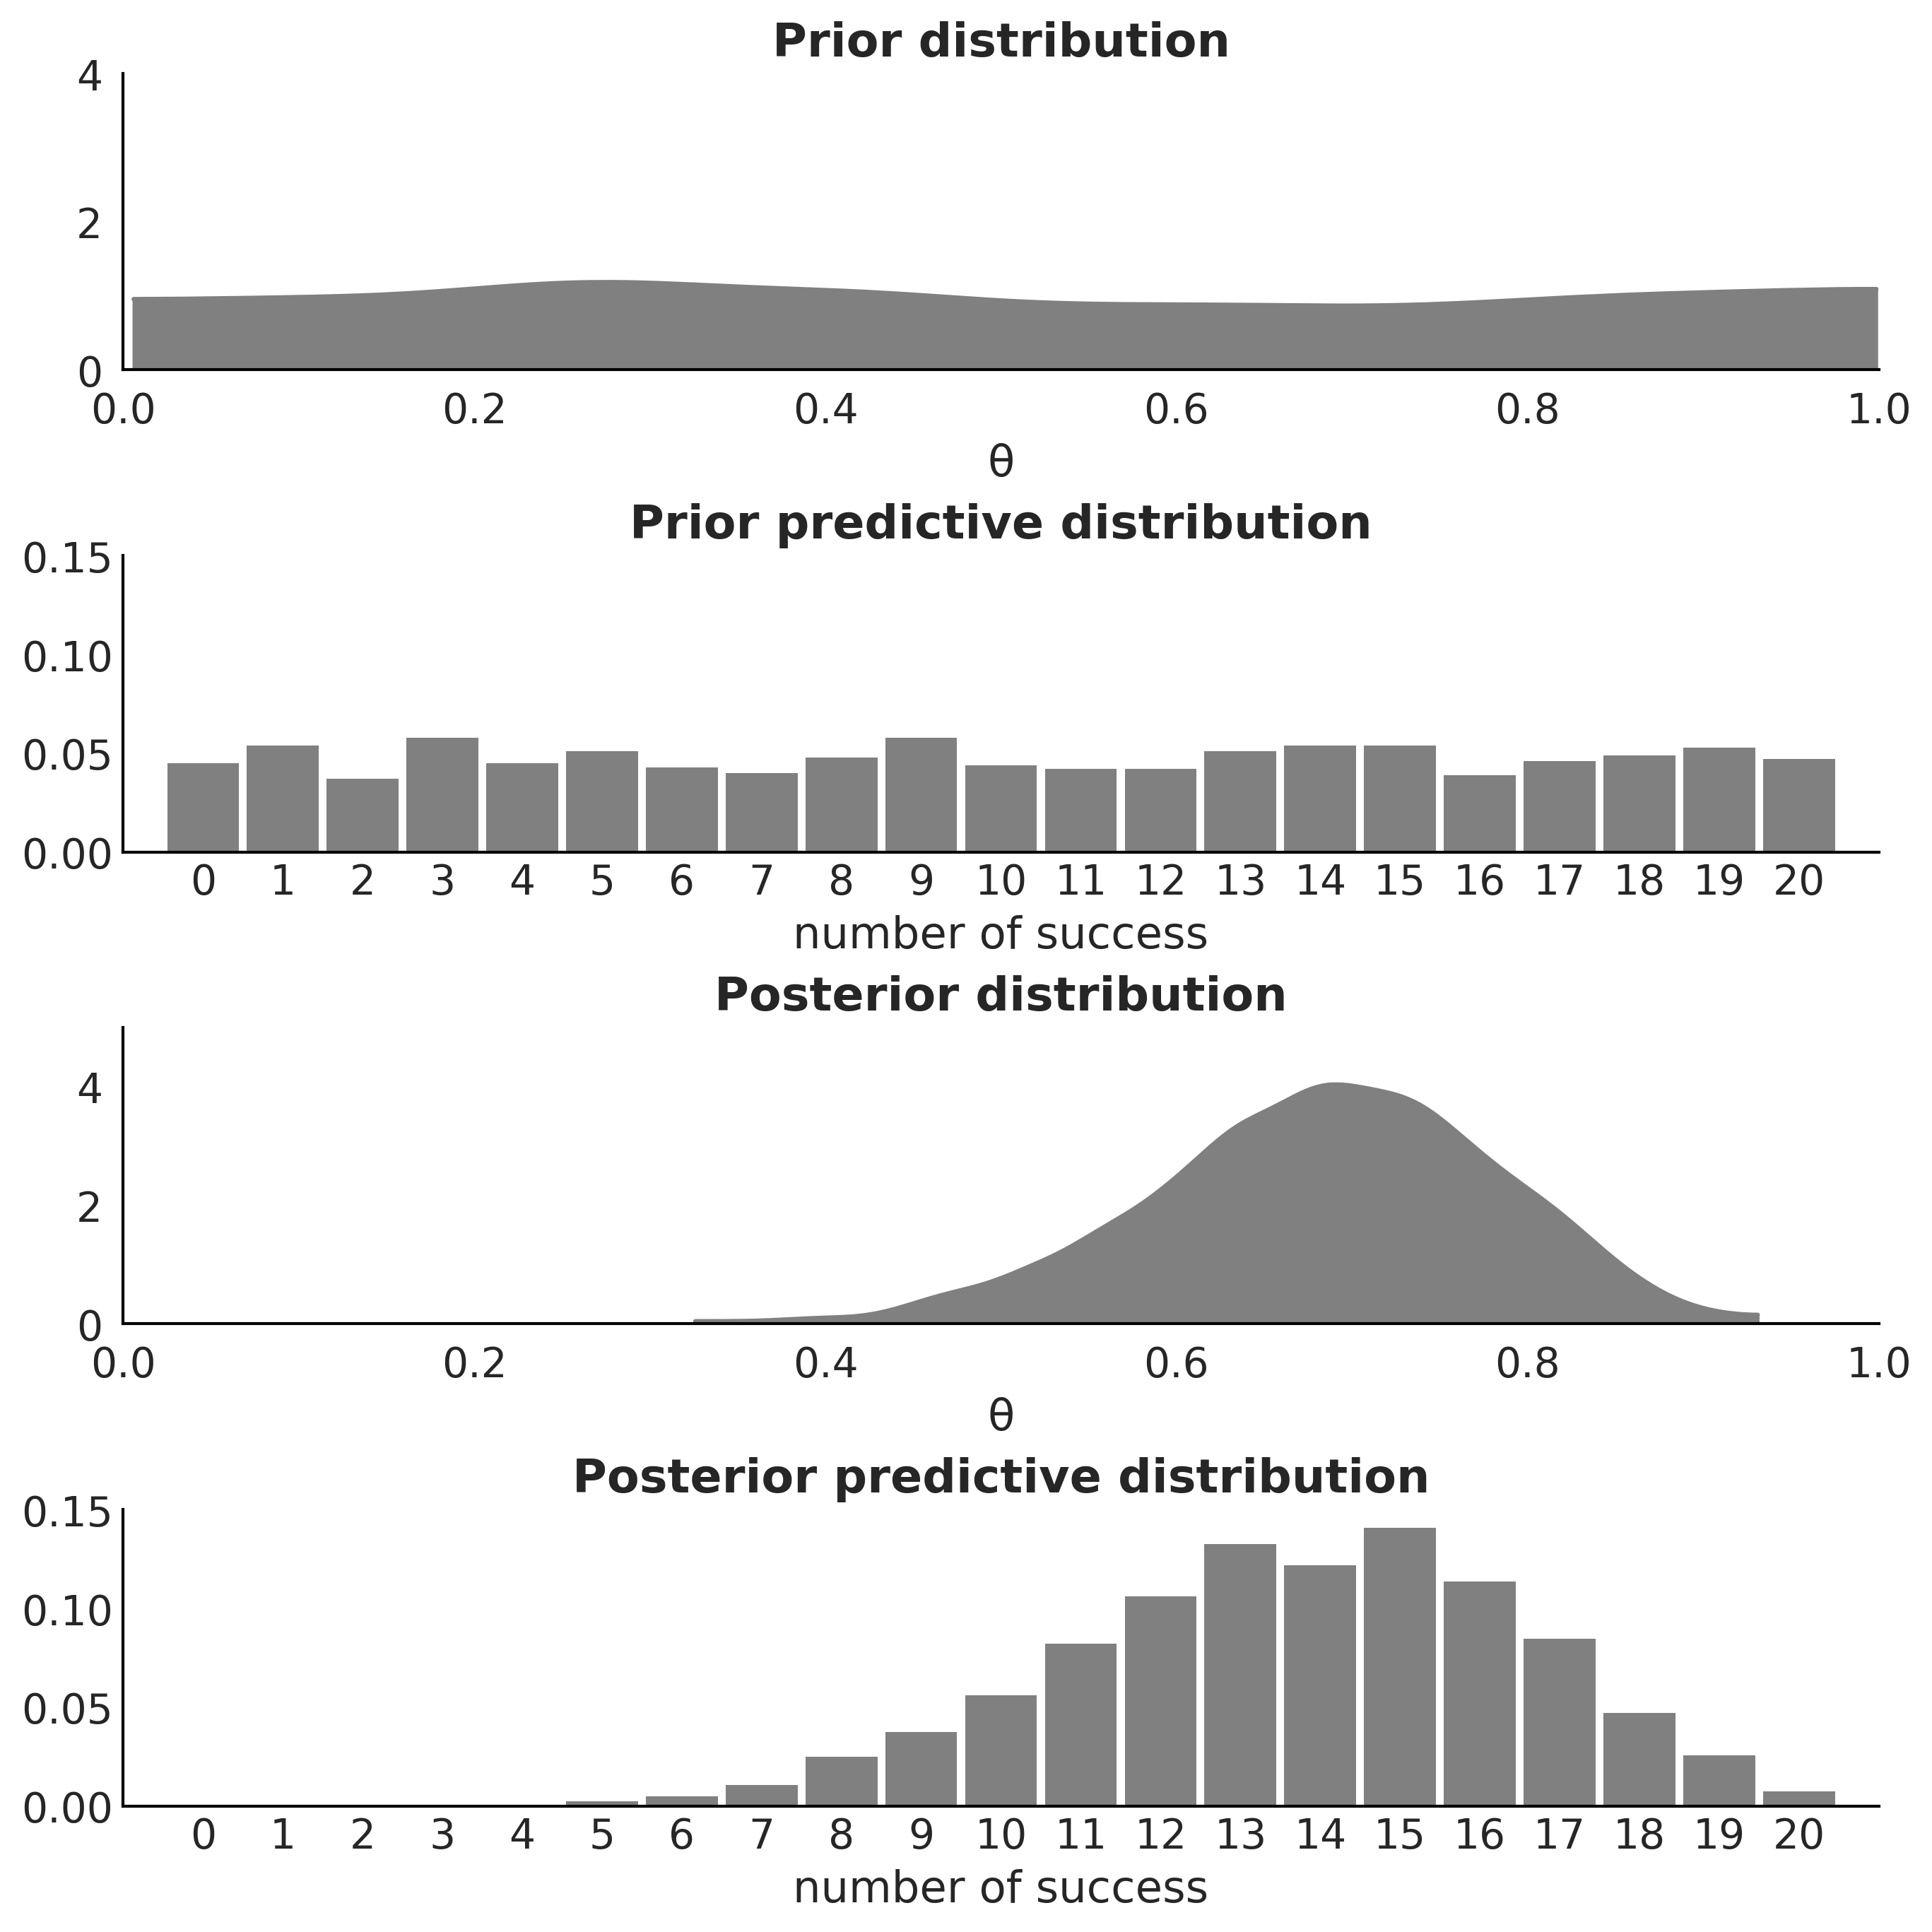

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists):
    az.plot_dist(dist.sum(-1), 
                 hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                 ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution", fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_ylim(0, 0.15)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(θ, 1000), plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("θ")

az.plot_dist(idata.posterior["θ"], plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 5)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("θ")

plt.show()

> From top plot to bottom plot we show:
>    - (1) samples from the prior distribution of the parameter $\theta$;
>    - (2) samples from the prior predictive distribution of the total number of successes;
>    - (3) posterior samples of the parameter $\theta$;
>    - (4) posterior predictive distribution of the total number of successes.

- prior predictive distribution

$$
p(\pmb{Y}^{*}) = \int_{\Theta} p(\pmb{Y}^{*} \mid \pmb{\theta})p(\pmb{\theta})d\pmb{\theta}
$$

This is the expected distribution of the data according to the model (prior and likelihood). That is the data we expect, given the model, before actually seeing any observed data $\pmb{Y}^{*}$.

- posterior predictive distribution

$$
p(\tilde{\pmb{Y}} \mid \pmb{Y}) = \int_{\Theta} p(\tilde{\pmb{Y}} \mid \pmb{\theta})p(\pmb{\theta} \mid \pmb{Y})d\pmb{\theta}
$$

This is the distribution of expected, future, data $\tilde{\pmb{Y}}$ according to the posterior $p(\pmb{\theta} \mid \pmb{Y})$, which in turn is a consequence of the model (prior and likelihood) and observed data.


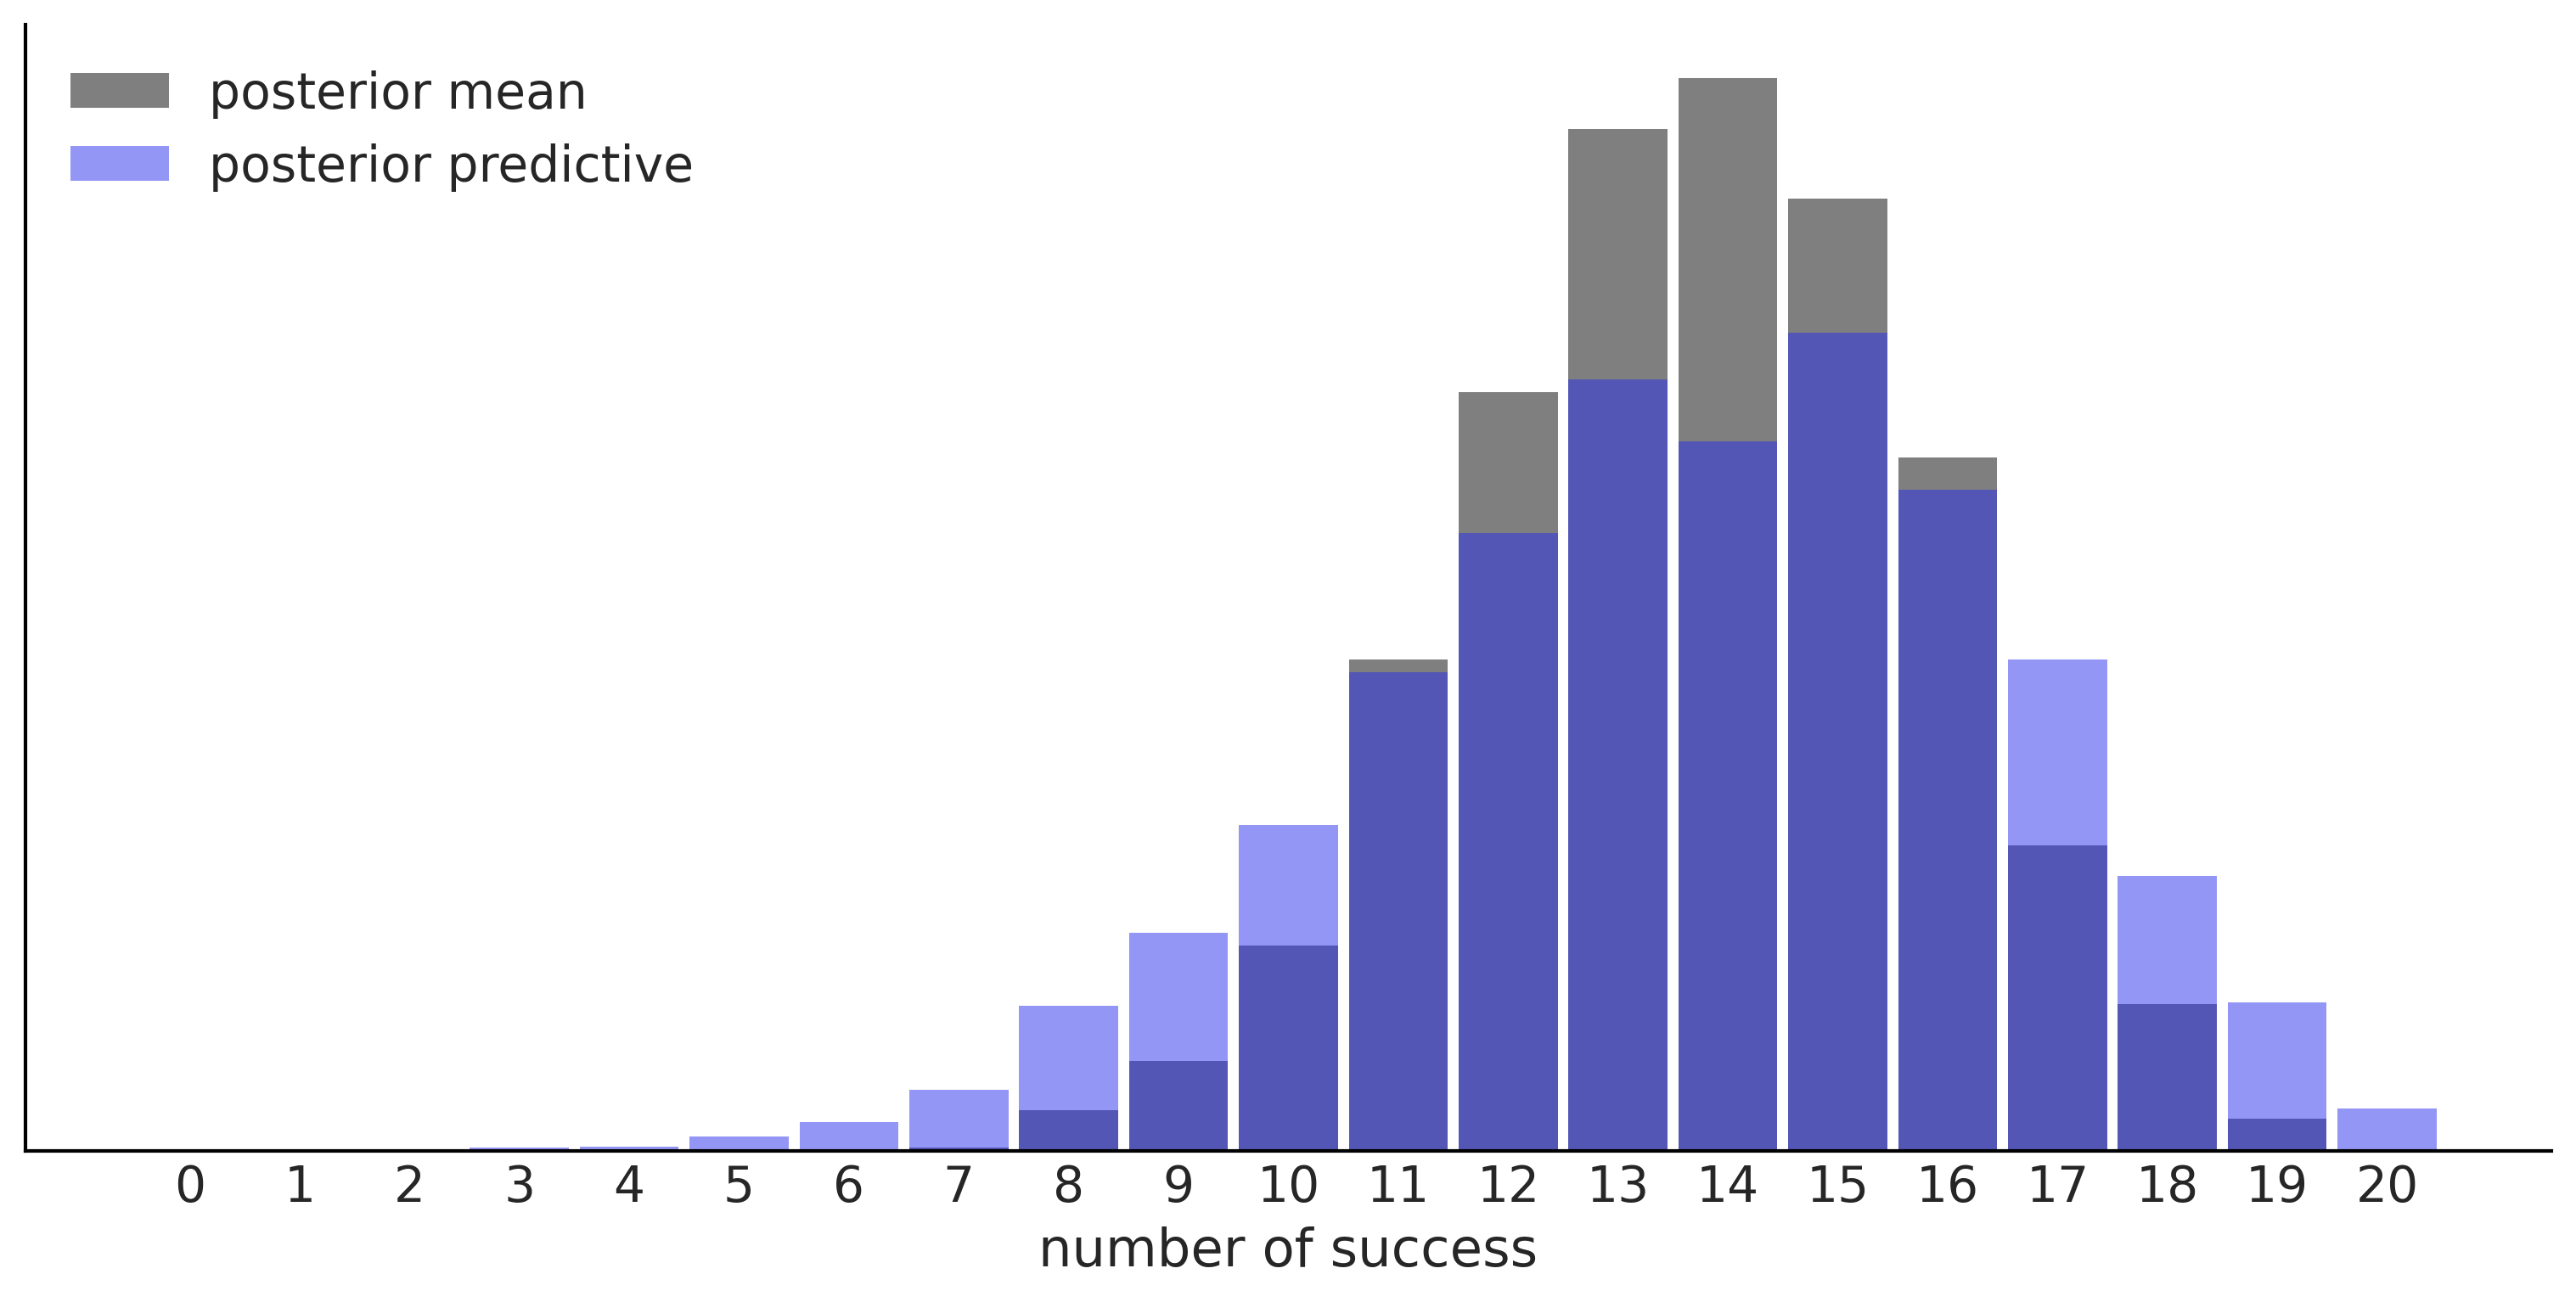

In [ ]:
predictions = (stats.binom(n=1, p=idata.posterior["θ"].mean()).rvs((4000, len(Y))),
               pred_dists[1])

for d, c, l in zip(predictions, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(-1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")

plt.show()

> Predictions for the Beta-Binomial model, using the posterior mean (gray histogram) vs predictions using the entire posterior, i.e. the posterior predictive distribution (blue histogram)

## 1.4. A Few Options to Quantify Your Prior Information

### 1.4.1. Conjugate Priors

A prior is conjugate to a likelihood if the posterior belongs to the same family of distributions as the prior.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

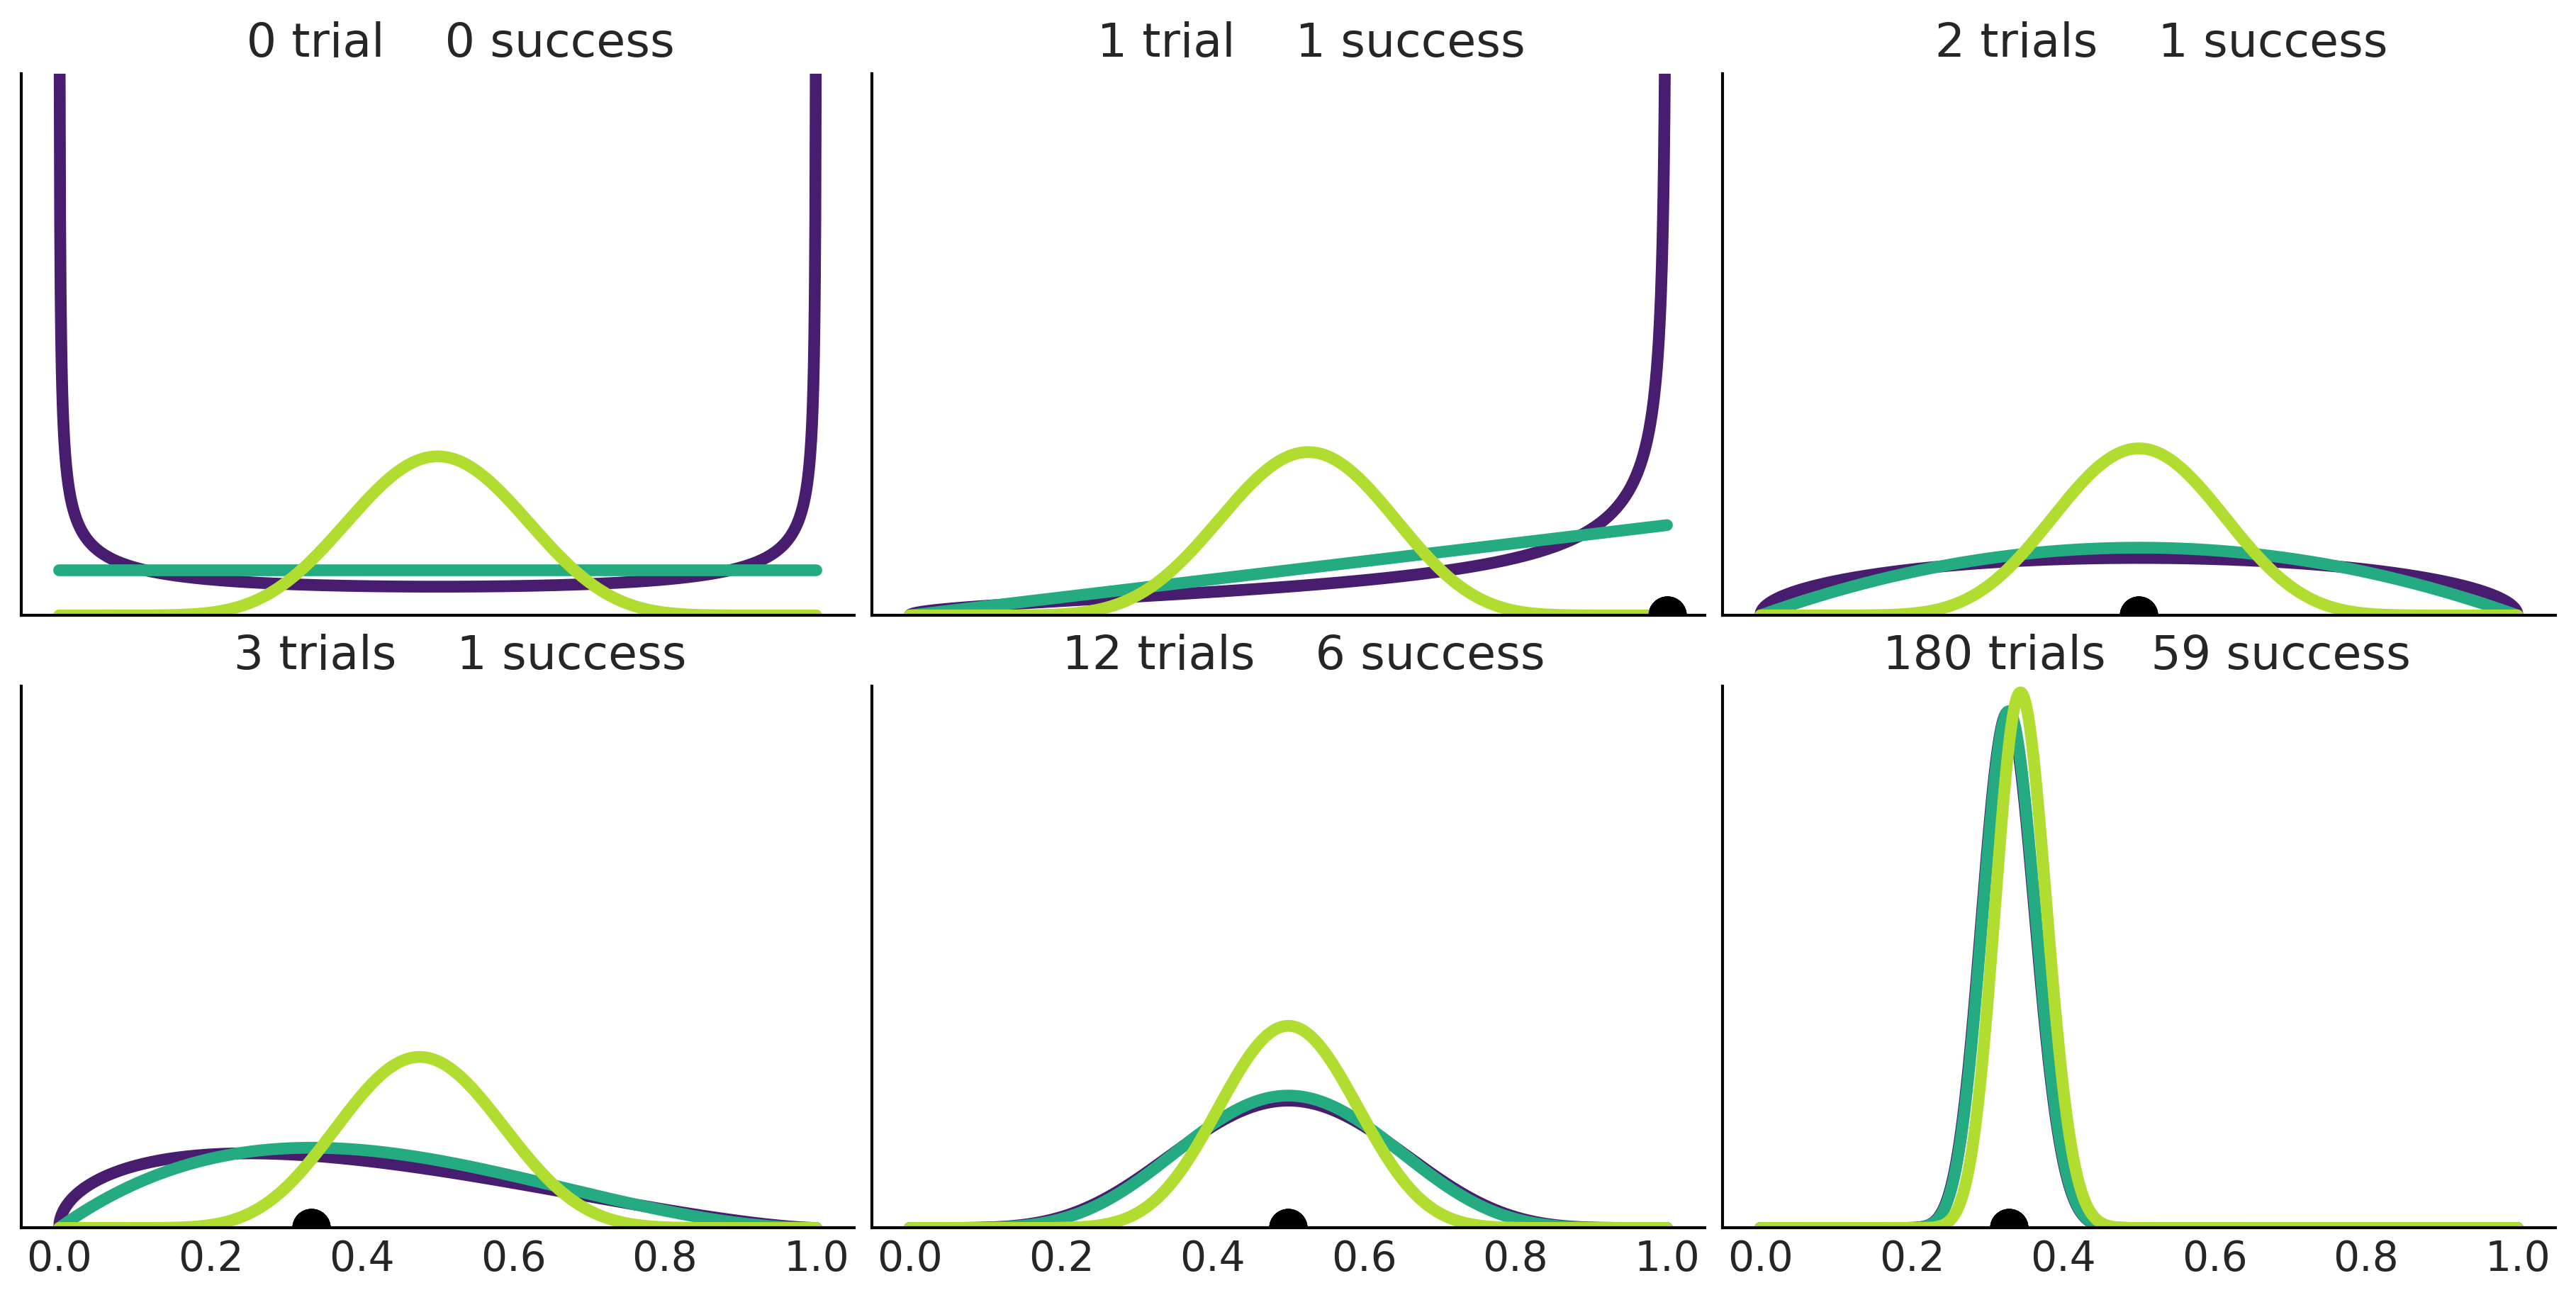

In [ ]:
_, axes = plt.subplots(2,3, figsize=(12, 6), sharey=True, sharex=True,
                     constrained_layout=True)
axes = np.ravel(axes)

n_trials = [0, 1, 2, 3, 12, 180]
success = [0, 1, 1, 1, 6, 59]
data = zip(n_trials, success)

beta_params = [(0.5, 0.5), (1, 1), (10, 10)]
θ = np.linspace(0, 1, 1500)
for idx, (N, y) in enumerate(data):
    s_n = ('s' if (N > 1) else '')
    for jdx, (a_prior, b_prior) in enumerate(beta_params):
        p_theta_given_y = stats.beta.pdf(θ, a_prior + y, b_prior + N - y)

        axes[idx].plot(θ, p_theta_given_y, lw=4, color=viridish[jdx])
        axes[idx].set_yticks([])
        axes[idx].set_ylim(0, 12)
        axes[idx].plot(np.divide(y, N), 0, color='k', marker='o', ms=12)
        axes[idx].set_title(f'{N:4d} trial{s_n} {y:4d} success')

plt.show()

> Successive prior updating starting from 3 different priors and increasing the number of trials (and possible the number of successes too). The black dot represents the sampling proportion estimator $\hat{\theta} = \frac{y}{n}$.

- Panels 3 and 5 show the results for 2 trials with 1 success and 12 trials with 6 success, for these cases, the sampling proportion estimator $\hat{\theta} = \frac{y}{n}$ (black dot) is the same 0.5 for both cases (the posterior mode is also 0.5), although the width of the posteriors are concentrated in panel 5 reflecting that the number of observations is larger and thus uncertainty lower.
- We can see how different priors converge to the same posterior distribution as the number of observations increase.
- In the limit of infinite data, the posteriors (irrespective of priors used to compute those posteriors) will have all its density at $\hat{\theta} = \frac{y}{n}$.

The results from many non-Bayesian methods can be understood as the **maximum a posteriori** (MAP) from Bayesian methods under some particular priors

### 1.4.2. Objective Priors

Objective priors are priors that have the least possible influence on a given analysis. 

1. One procedure to obtain objective priors is known as Jeffreys’ prior (JP). 
    - JPs have the property of being invariant under reparametrization, i.e. writing an expression in a different but mathematically equivalent way.
    - Unless we use JPs there is no guarantee that two (or more) parameterization of a model will necessarily lead to posteriors that are coherent.

2. Another possible route is to obtain a prior by maximizing the expected Kullback-Leibler divergence between the prior and posterior.These kind of priors are known as Bernardo reference priors. 

Bernardo reference priors and Jeffreys’ prior do not necessarily agree. Additionally, objective priors may not exist or be difficult to derive for complicated models.

### 1.4.3. Maximum Entropy Priors

Yet another way to justify a choice of priors is to pick the prior with the highest entropy.

In order to obtain a maximum entropy prior we need to solve an optimization problem taking into account a set of constraints. Mathematically this can be done using what is known as Lagrangian multipliers.

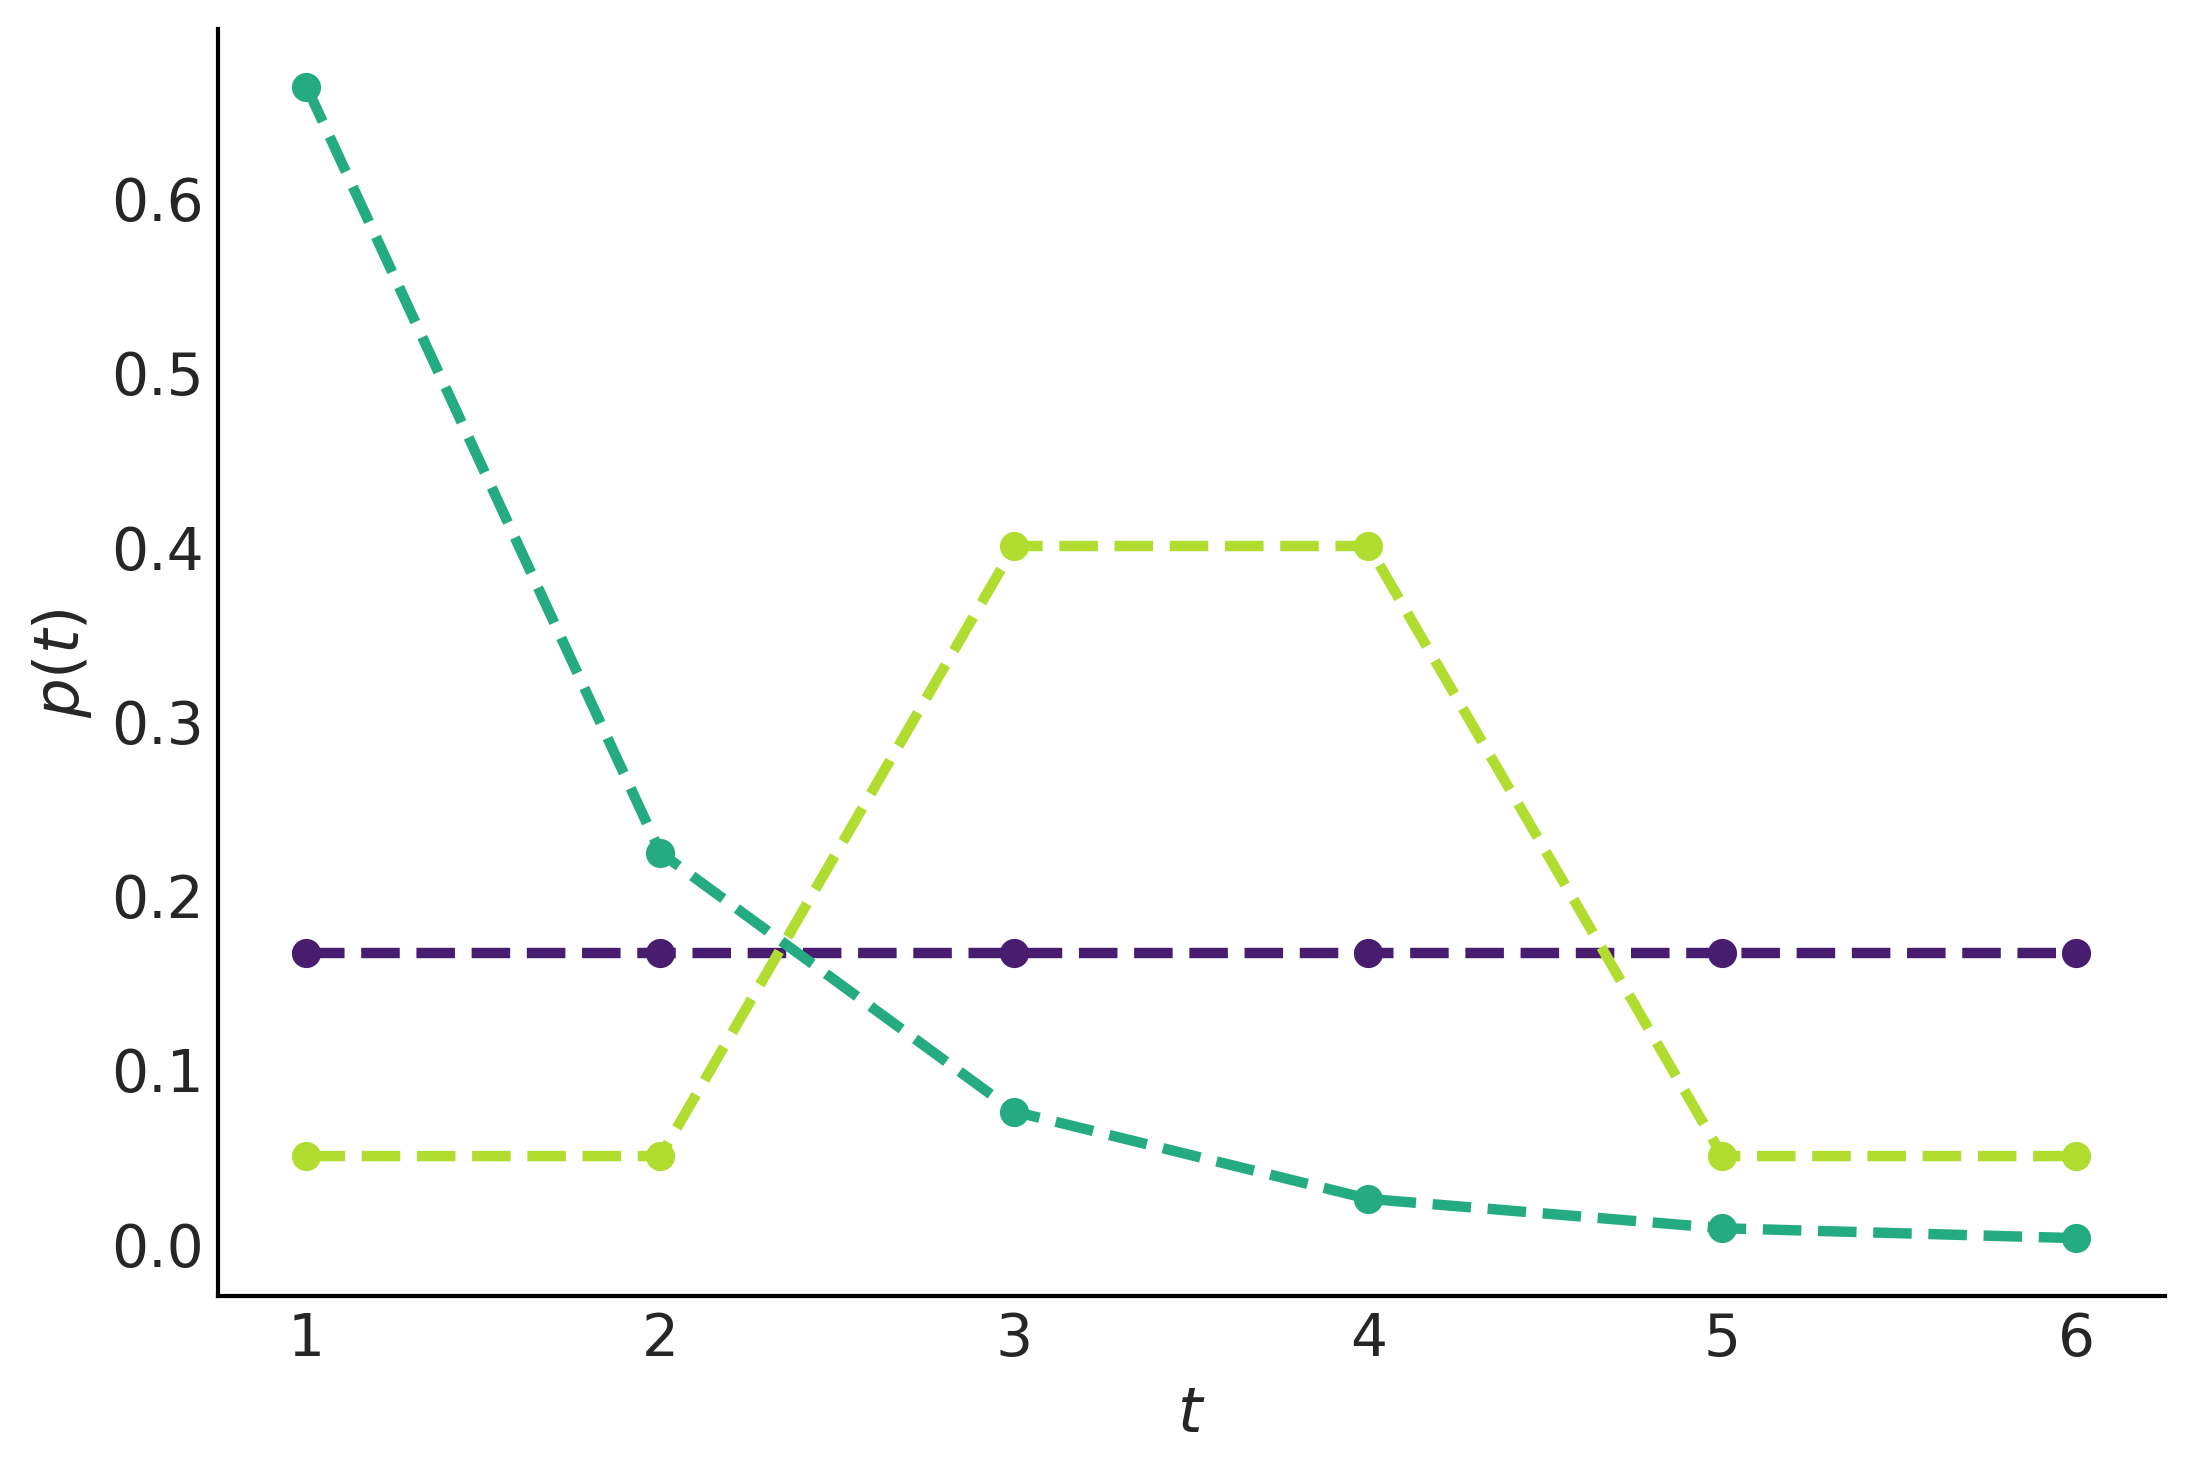

In [ ]:
cons = [[{"type": "eq", "fun": lambda x: np.sum(x) - 1}],
        [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
         {"type": "eq", "fun": lambda x: 1.5 - np.sum(x * np.arange(1, 7))}],
        [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
         {"type": "eq", "fun": lambda x: np.sum(x[[2, 3]]) - 0.8}]]

max_ent = []
for i, c in enumerate(cons):
    val = minimize(lambda x: -entropy(x), x0=[1/6]*6, bounds=[(0., 1.)] * 6,
                   constraints=c)['x']
    max_ent.append(entropy(val))
    plt.plot(np.arange(1, 7), val, 'o--', color=viridish[i], lw=2.5)
plt.xlabel("$t$")
plt.ylabel("$p(t)$")
plt.show()

The above figure (Fig. 1.9) shows 3 discrete distributions obtained by entropy maximization.
- The purple distribution is obtained under no constraint, and we are happy to find that this is indeed the Uniform distribution.
- The second distribution, in cyan, is obtained under the constraint that we know the mean value of the distribution. In this example the mean value is 1.5). Under this constraint we get an Exponential-like distribution.
- The last one in yellow-green was obtained under the restriction that the value 3 and 4 are known to appear with a probability of 0.8

All distributions were computed under two constraints that probabilities can only take values in the interval $[0, 1]$ and that the total probability must be 1. As these are general constraints for valid probability distribution we can think of them as intrinsic or even ontological constraints. For that reason we say that the purple distribution was obtained under no-constraint.

In [ ]:
ite = 100_000
entropies = np.zeros((3, ite))
for idx in range(ite):
    rnds = np.zeros(6)
    total = 0
    x_ = np.random.choice(np.arange(1, 7), size=6, replace=False)
    for i in x_[:-1]:
        rnd = np.random.uniform(0, 1-total)
        rnds[i-1] = rnd
        total = rnds.sum()
    rnds[-1] = 1 - rnds[:-1].sum()
    H = entropy(rnds)
    entropies[0, idx] = H
    if abs(1.5 - np.sum(rnds * x_)) < 0.01:
        entropies[1, idx] = H
    prob_34 = sum(rnds[np.argwhere((x_ == 3) | (x_ == 4)).ravel()])
    if abs(0.8 - prob_34) < 0.01:
        entropies[2, idx] = H

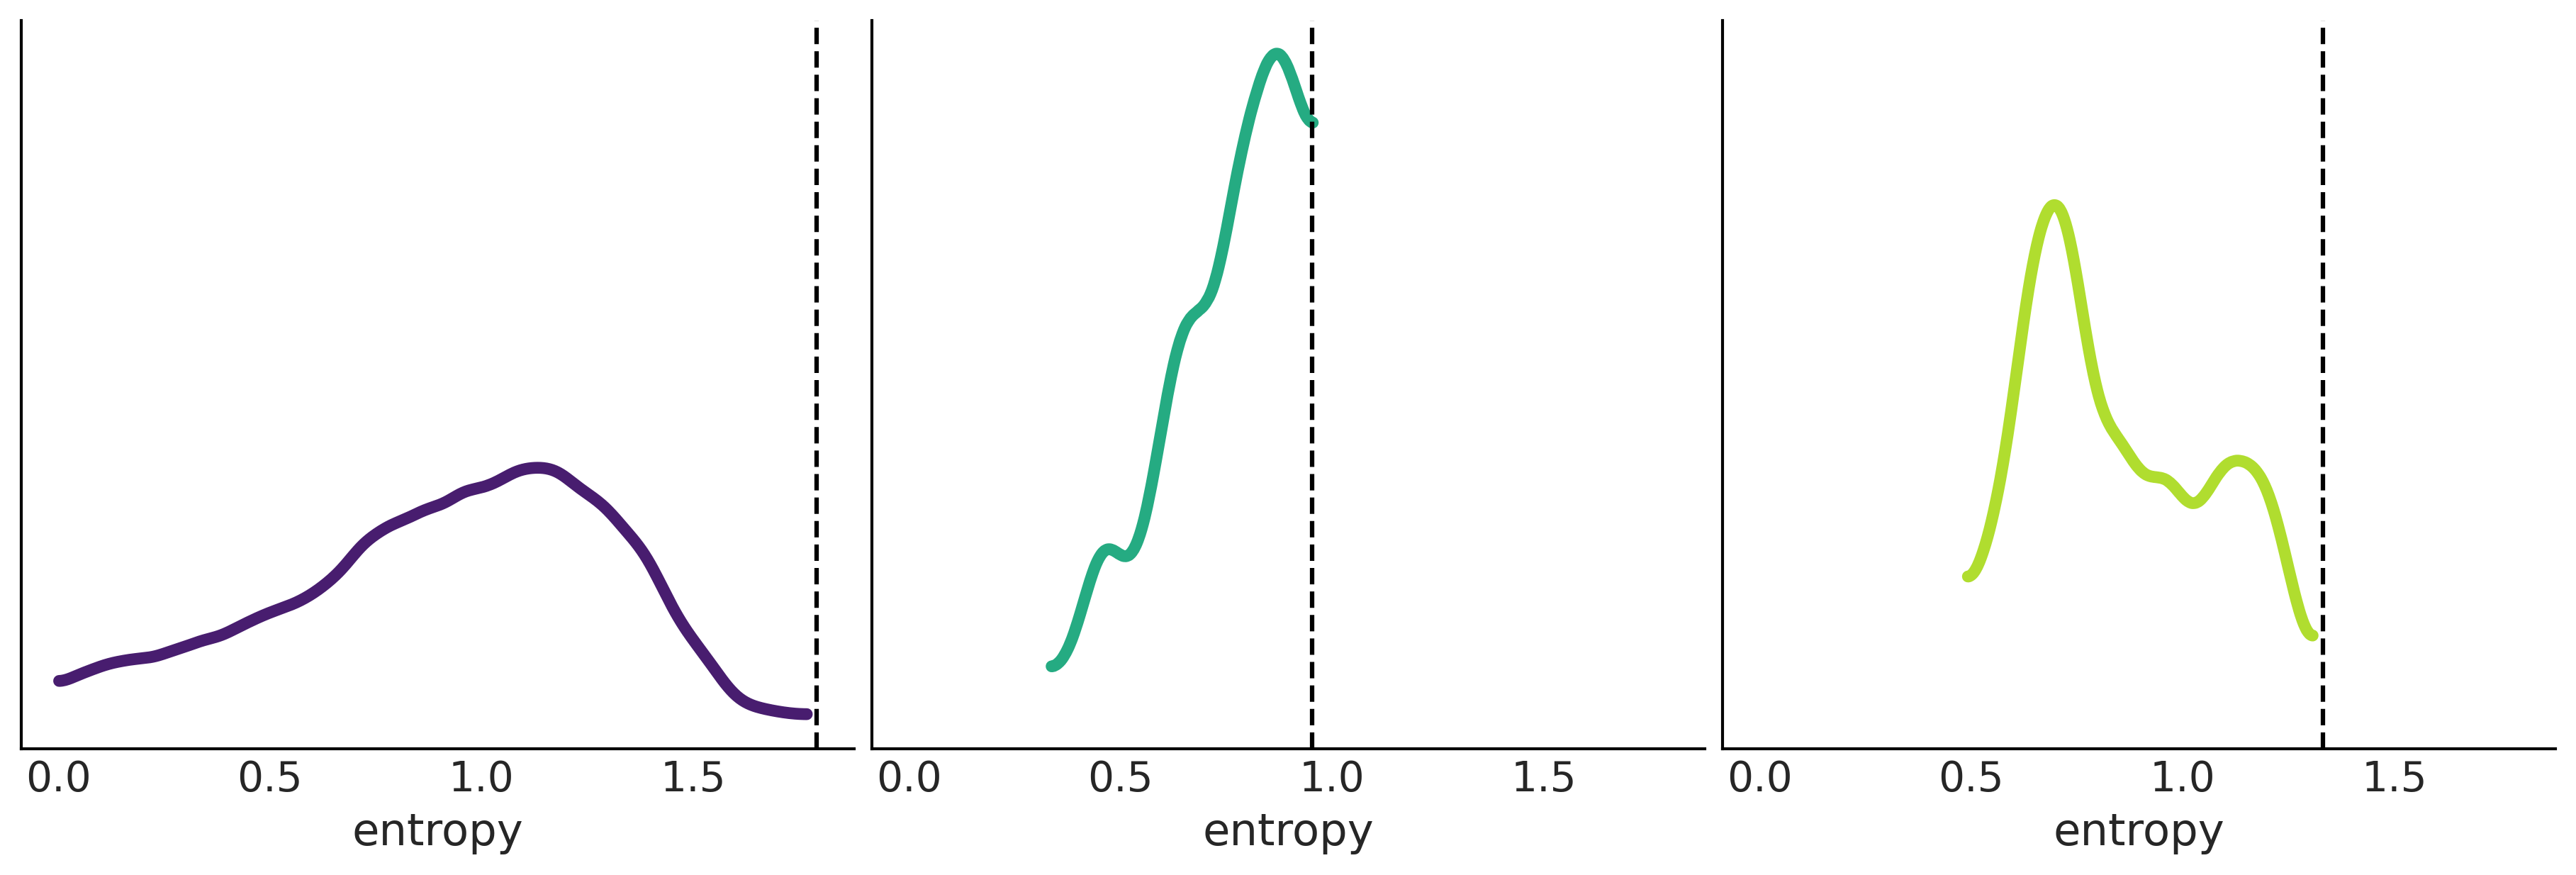

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True, constrained_layout=True)

for i in range(3):
    az.plot_kde(entropies[i][np.nonzero(entropies[i])], ax=ax[i], plot_kwargs={"color":viridish[i], "lw":4})
    ax[i].axvline(max_ent[i], 0, 1, ls="--")
    ax[i].set_yticks([])
    ax[i].set_xlabel("entropy")

plt.show()

The above figure (Fig. 1.10) shows the distribution of entropies computed for randomly generated samples under the exact same conditions as the 3 distributions in Fig. 1.9. The dotted vertical line indicates the value for the distributions with maximum entropy. 

We can see that none of the randomly generated distributions have an entropy larger that the distributions with maximum entropy. While this is not a proof, this experiment seems to suggest that there is no distribution with higher entropy than the distributions in Fig. 1.9, which is in total agreement with what the theory tells us.

Similar to objective priors, MaxEnt prior may not exist or are difficult to derive.

### 1.4.4. Weakly Informative Priors and Regularization Priors

What constitutes a weakly informative priors is usually not mathematically well defined as JPs or MaxEnt are. Instead they are more empirical and model-driven, that is they are defined through a combination of relevant domain expertise and the model itself. 

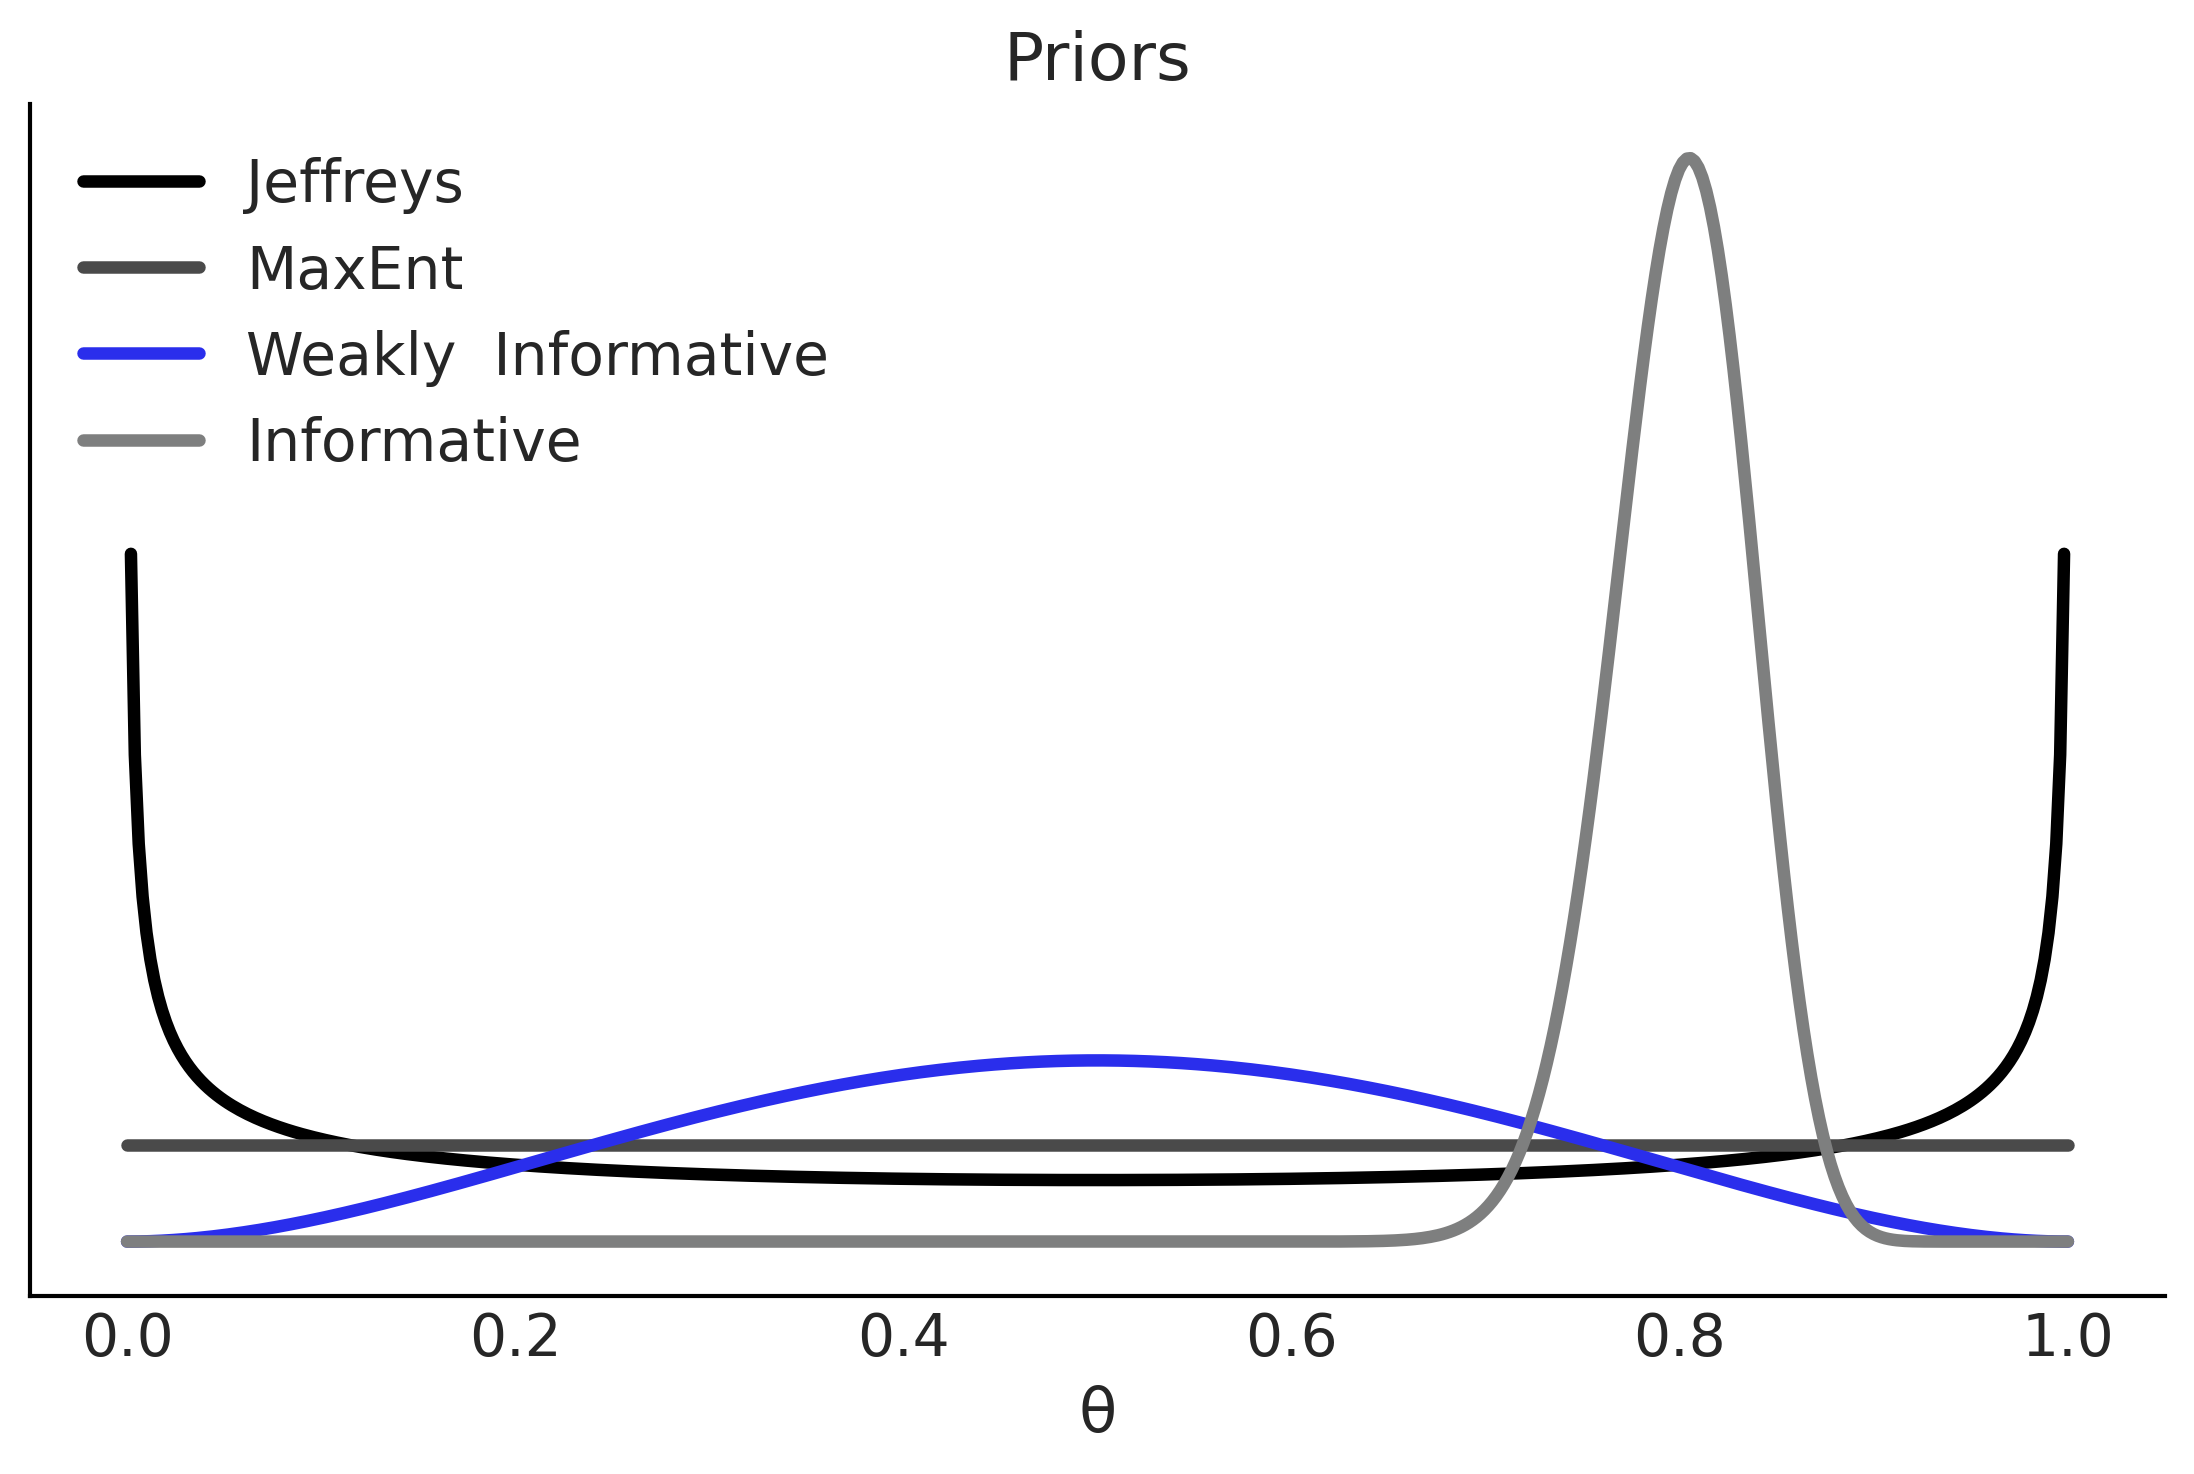

In [ ]:
x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys", "MaxEnt", "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = stats.beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}", lw=3)
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()

plt.show()

> Prior informativeness spectrum: While Jeffreys and MaxEnt priors are uniquely defined for a binomial likelihood, weakly informative and informative priors are not and instead depend on previous information and practitioner’s modeling decisions.

The weakly informative prior gives preference to a value of $\theta=0.5$ while still being broad or relatively vague about other values. 

The informative prior is narrowly centered around $\theta=0.8$.

Using informative priors is a valid option if we have good-quality information from theory, previous experiments, observational data, etc. As informative priors are very strong priors conveying a lot of information they generally require a stronger justification than other priors.

Because weakly-informative priors work to keep the posterior distribution within certain reasonable bounds, they are also known as regularizing priors. **Regularization is a procedure of adding information with the aim of solving an ill-posed problem or to reduce the chance of overfitting** and priors offer a principled way of performing regularization.

**Overfitting** occurs when a model generates predictions very close to the limited dataset used to fit it, but it fails to fit additional data and/or predict future observations reasonably well. That is it fails to generalize its predictions to a wider set of possible observations. The counterpart of overfitting is **underfitting**, which is when a model fails to adequately capture the underlying structure of the data.

### 1.4.5. Using Prior Predictive Distributions to Assess Priors

By sampling from the prior predictive distribution, the computer does the work of translating choices made in the parameter space into samples in the observed variable space.

Thinking in terms of observed values is generally easier than thinking in terms of the model’s parameters which makes model evaluation easier.